In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mydataset/data_methylation_cleaned_filtered.csv
/kaggle/input/mydataset/data_clinical_filtered.csv
/kaggle/input/dna-methylation/data_methylation_imputed.csv
/kaggle/input/myproject/data_methylation_cleaned_filtered.csv
/kaggle/input/myproject/data_clinical_filtered.csv


In [2]:
!pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 71.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you h

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.cluster.hierarchy import linkage, dendrogram
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import pdist
from matplotlib.patches import Patch
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter
import umap
from sklearn.manifold import TSNE

In [5]:
# Set random seed for reproducibility
np.random.seed(1)

# SECTION 1: Load Data

In [6]:

# Load the methylation data (rows: methylation profiles, columns: sample IDs)
methylation_data = pd.read_csv('/kaggle/input/dna-methylation/data_methylation_imputed.csv', index_col=0)
assert methylation_data.shape[0] > 0, "Methylation data is empty"
assert methylation_data.shape[1] > 0, "Methylation data has no columns"

# Strip suffixes (e.g., "-01") from methylation sample IDs (column names)
methylation_data.columns = methylation_data.columns.str.extract(r'(^TCGA-\w\w-\w{4})')[0]

# Drop columns that didn't match the pattern (non-TCGA IDs)
methylation_data = methylation_data.loc[:, methylation_data.columns.notna()]

# Load the clinical data (e.g., columns: PATIENT_ID, SUBTYPE)
clinical_data = pd.read_csv('/kaggle/input/mydataset/data_clinical_filtered.csv')
assert clinical_data.shape[0] > 0, "Clinical data is empty"
assert clinical_data.shape[1] == 2, "Clinical data should only have PATIENT_ID and SUBTYPE columns"

#  Filter out the "Normal" subtype
clinical_data = clinical_data[clinical_data["SUBTYPE"] != "BRCA_Normal"]

#  Filter methylation data to keep only the remaining patient IDs
remaining_ids = clinical_data["PATIENT_ID"].values
methylation_data = methylation_data[remaining_ids]  # This now works, since IDs match

print(f"Methylation data shape (after filtering): {methylation_data.shape}")
print(f"Clinical data shape (after filtering): {clinical_data.shape}")

# Display the first few rows of each dataset
display(clinical_data.head())
display(methylation_data.head())

# Check for the intersection between the methylation sample IDs and clinical sample IDs
methylation_sample_ids = set(methylation_data.columns)
clinical_sample_ids = set(clinical_data['PATIENT_ID'])

common_sample_ids = list(methylation_sample_ids.intersection(clinical_sample_ids))

# Print counts
print(f"Number of methylation sample IDs: {len(methylation_sample_ids)}")
print(f"Number of clinical information sample IDs: {len(clinical_sample_ids)}")
print(f"Number of common sample IDs: {len(common_sample_ids)}")


Methylation data shape (after filtering): (22601, 931)
Clinical data shape (after filtering): (931, 2)


PATIENT_ID    SUBTYPE
0  TCGA-3C-AAAU  BRCA_LumA
1  TCGA-3C-AALI  BRCA_Her2
2  TCGA-3C-AALJ  BRCA_LumB
3  TCGA-3C-AALK  BRCA_LumA
4  TCGA-4H-AAAK  BRCA_LumA

0                          TCGA-3C-AAAU  TCGA-3C-AALI  TCGA-3C-AALJ  \
GENE_POSITION                                                         
ATP2A1_1stExon                 0.678483      0.261045      0.850628   
MEOX2_1stExon                  0.100005      0.044714      0.496529   
HOXD3_5'UTR                    0.875122      0.680860      0.774736   
PANX1_1stExon                  0.028658      0.027581      0.032019   
KIAA1409;COX8C_Body;5'UTR      0.954225      0.933860      0.941596   

0                          TCGA-3C-AALK  TCGA-4H-AAAK  TCGA-5L-AAT0  \
GENE_POSITION                                                         
ATP2A1_1stExon                 0.733004      0.796488      0.411649   
MEOX2_1stExon                  0.272595      0.116450      0.251992   
HOXD3_5'UTR                    0.626697      0.638573      0.635766   
PANX1_1stExon                  0.024139      0.030863      0.062025   
KIAA1409;COX8C_Body;5'UTR      0.936462      0.945290      0.946880   

0                          TCGA-5T-A9QA  TCGA-A1-A0SD  TCGA-A1-A0SE  \
GENE_POSITION                                                         
ATP2A1_1stExon                 0.927894      0.651621      0.654524   
MEOX2_1stExon                  0.802537      0.353951      0.265736   
HOXD3_5'UTR                    0.906689      0.645124      0.804874   
PANX1_1stExon                  0.038965      0.044071      0.022903   
KIAA1409;COX8C_Body;5'UTR      0.939998      0.937432      0.913657   

0                          TCGA-A1-A0SF  ...  TCGA-UL-AAZ6  TCGA-UU-A93S  \
GENE_POSITION                            ...                               
ATP2A1_1stExon                 0.469212  ...      0.824999      0.929480   
MEOX2_1stExon                  0.129155  ...      0.113316      0.168558   
HOXD3_5'UTR                    0.696195  ...      0.896749      0.813861   
PANX1_1stExon                  0.019860  ...      0.035211      0.026175   
KIAA1409;COX8C_Body;5'UTR      0.941637  ...      0.944888      0.944649   

0                          TCGA-V7-A7HQ  TCGA-W8-A86G  TCGA-WT-AB41  \
GENE_POSITION                                                         
ATP2A1_1stExon                 0.692709      0.607469      0.862935   
MEOX2_1stExon                  0.061482      0.162464      0.200388   
HOXD3_5'UTR                    0.488089      0.612408      0.659995   
PANX1_1stExon                  0.025063      0.023322      0.029156   
KIAA1409;COX8C_Body;5'UTR      0.941954      0.895781      0.949527   

0                          TCGA-WT-AB44  TCGA-XX-A899  TCGA-XX-A89A  \
GENE_POSITION                                                         
ATP2A1_1stExon                 0.636552      0.747720      0.560793   
MEOX2_1stExon                  0.090186      0.168586      0.079366   
HOXD3_5'UTR                    0.736100      0.585903      0.812665   
PANX1_1stExon                  0.026199      0.025572      0.026861   
KIAA1409;COX8C_Body;5'UTR      0.932573      0.939141      0.905925   

0                          TCGA-Z7-A8R5  TCGA-Z7-A8R6  
GENE_POSITION                                          
ATP2A1_1stExon                 0.852534      0.433840  
MEOX2_1stExon                  0.127861      0.077306  
HOXD3_5'UTR                    0.332882      0.615238  
PANX1_1stExon                  0.030123      0.027423  
KIAA1409;COX8C_Body;5'UTR      0.950901      0.943503  

[5 rows x 931 columns]

Number of methylation sample IDs: 931
Number of clinical information sample IDs: 931
Number of common sample IDs: 931


Samples per subtype:
SUBTYPE
BRCA_LumA     488
BRCA_LumB     197
BRCA_Basal    168
BRCA_Her2      78


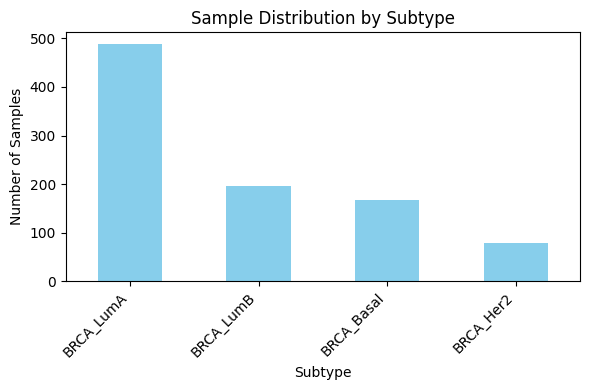

In [12]:
import matplotlib.pyplot as plt

# Count samples per subtype
subtype_counts = clinical_data['SUBTYPE'].value_counts()

# Display the counts
print("Samples per subtype:")
print(subtype_counts.to_string())

# Plot the distribution
plt.figure(figsize=(6, 4))
subtype_counts.plot(kind='bar', color='skyblue')
plt.title('Sample Distribution by Subtype')
plt.xlabel('Subtype')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# SECTION 2: Mutual Feature Selection

In [7]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

print("Performing mutual information feature selection...")

# Set the feature limit
filter_limit = 600

# Transpose methylation data (rows as samples, columns as features)
methylation_data_transposed = methylation_data.T

# Ensure the sample IDs in clinical data match those in methylation data
common_sample_ids = methylation_data_transposed.index.intersection(clinical_data['PATIENT_ID'])
methylation_data_transposed = methylation_data_transposed.loc[common_sample_ids]
clinical_data_filtered = clinical_data.set_index('PATIENT_ID').loc[common_sample_ids]

# Add the SUBTYPE column from clinical data as the target
target = clinical_data_filtered['SUBTYPE']

# Apply SelectKBest with mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=filter_limit)
selected_features = selector.fit_transform(methylation_data_transposed, target)

# Get the mask of selected features
selected_feature_names = methylation_data_transposed.columns[selector.get_support()]

# Create a DataFrame from the selected features
selected_features_df = pd.DataFrame(selected_features, index=common_sample_ids, columns=selected_feature_names)

print(f"Selected top {selected_features_df.shape[1]} features using mutual information.")

# Display the head to inspect
display(selected_features_df.head())


Performing mutual information feature selection...
Selected top 600 features using mutual information.


GENE_POSITION  RUNX3_Body  PMEPA1_TSS1500;TSS200  NMUR1_Body  MCM5_TSS1500  \
0                                                                            
TCGA-3C-AAAU     0.382230               0.796788    0.849873      0.887549   
TCGA-3C-AALI     0.747274               0.514408    0.700086      0.470768   
TCGA-3C-AALJ     0.638983               0.507956    0.735928      0.874746   
TCGA-3C-AALK     0.605766               0.807561    0.707952      0.889974   
TCGA-4H-AAAK     0.533831               0.826956    0.622900      0.914649   

GENE_POSITION  NINJ2_TSS200  RAD9B;VPS29_Body;TSS1500  C1orf59_TSS1500;TSS200  \
0                                                                               
TCGA-3C-AAAU       0.205615                  0.244951                0.713730   
TCGA-3C-AALI       0.578509                  0.197661                0.430957   
TCGA-3C-AALJ       0.234091                  0.622423                0.314755   
TCGA-3C-AALK       0.541346                  0.639098                0.679481   
TCGA-4H-AAAK       0.475455                  0.540163                0.707631   

GENE_POSITION  VWC2_5'UTR  PPP1R3D;C20orf177_TSS1500;1stExon  PYY;NAGS_TSS200  \
0                                                                               
TCGA-3C-AAAU     0.614818                           0.950396         0.299591   
TCGA-3C-AALI     0.243543                           0.354953         0.549116   
TCGA-3C-AALJ     0.520437                           0.922434         0.452516   
TCGA-3C-AALK     0.330203                           0.958077         0.362386   
TCGA-4H-AAAK     0.621952                           0.954194         0.514334   

GENE_POSITION  ...  C6orf15_1stExon  KCNK12_TSS1500  TMEM158_TSS1500  \
0              ...                                                     
TCGA-3C-AAAU   ...         0.958188        0.089392         0.720321   
TCGA-3C-AALI   ...         0.945692        0.101105         0.865132   
TCGA-3C-AALJ   ...         0.951371        0.612497         0.866929   
TCGA-3C-AALK   ...         0.953612        0.418086         0.798857   
TCGA-4H-AAAK   ...         0.943197        0.494140         0.848674   

GENE_POSITION  CD97_Body  CAPN9_TSS1500  TEX19_TSS1500  KCNQ1_Body  \
0                                                                    
TCGA-3C-AAAU    0.094166       0.442768       0.913565    0.755254   
TCGA-3C-AALI    0.325089       0.382688       0.723493    0.584383   
TCGA-3C-AALJ    0.482202       0.438780       0.819758    0.609076   
TCGA-3C-AALK    0.461800       0.626962       0.886105    0.555882   
TCGA-4H-AAAK    0.212821       0.687100       0.819913    0.615176   

GENE_POSITION  SYNPO2L_Body;1stExon;5'UTR  ALDH1A3_Body  A2ML1_Body  
0                                                                    
TCGA-3C-AAAU                     0.951270      0.866693    0.913666  
TCGA-3C-AALI                     0.916750      0.696772    0.933253  
TCGA-3C-AALJ                     0.924245      0.715644    0.856873  
TCGA-3C-AALK                     0.915598      0.640974    0.850226  
TCGA-4H-AAAK                     0.893813      0.761174    0.817014  

[5 rows x 600 columns]

 #  SECTION 3: Z-score Normalization 

In [10]:
# Step 1: Z-score normalization on the filtered methylation data (methylation_data_selected from mRMR)
methylation_scaled = zscore(selected_features, axis=1)
assert np.allclose(np.mean(methylation_scaled), 0, atol=1e-6), "Z-score normalization failed, mean not close to 0"
assert np.allclose(np.std(methylation_scaled), 1, atol=1e-6), "Z-score normalization failed, std not close to 1"

# Convert the normalized data back to a DataFrame and set the index to sample IDs
normalized_df = pd.DataFrame(methylation_scaled, index=common_sample_ids)

# Ensure the normalized data shape is as expected
print(f"Normalized methylation data shape: {normalized_df.shape}")
assert methylation_scaled.shape == (len(common_sample_ids), filter_limit), \
    f"Unexpected shape after normalization: expected {(len(common_sample_ids), filter_limit)}, got {normalized_df.shape}"

# Display the head of the normalized data to ensure everything is fine
display(pd.DataFrame(normalized_df).head())

Normalized methylation data shape: (931, 600)


0         1         2         3         4         5    \
0                                                                          
TCGA-3C-AAAU -0.451208  0.856448  1.023898  1.142739 -1.008310 -0.884232   
TCGA-3C-AALI  0.734815 -0.117487  0.562103 -0.277211  0.117127 -1.276791   
TCGA-3C-AALJ  0.122115 -0.446757  0.543015  1.145711 -1.635781  0.050216   
TCGA-3C-AALK -0.046054  0.928540  0.447467  1.326565 -0.357175  0.114930   
TCGA-4H-AAAK -0.141511  1.037257  0.216670  1.389903 -0.376264 -0.116047   

                   6         7         8         9    ...       590       591  \
0                                                     ...                       
TCGA-3C-AAAU  0.594456  0.282453  1.340980 -0.711879  ...  1.365559 -1.374915   
TCGA-3C-AALI -0.422920 -1.108861 -0.701099  0.009547  ...  1.461032 -1.630192   
TCGA-3C-AALJ -1.285566 -0.392570  1.352756 -0.687459  ...  1.478388  0.007123   
TCGA-3C-AALK  0.309963 -1.376919  1.655480 -1.221487  ...  1.633915 -0.952476   
TCGA-4H-AAAK  0.557404  0.212857  1.548932 -0.219919  ...  1.504706 -0.301124   

                   592       593       594       595       596       597  \
0                                                                          
TCGA-3C-AAAU  0.615245 -1.359858 -0.260249  1.224801  0.725437  1.343738   
TCGA-3C-AALI  1.166180 -0.810401 -0.599587  0.647773  0.138626  1.355103   
TCGA-3C-AALJ  1.111772 -0.558573 -0.747094  0.906974 -0.007732  1.360618   
TCGA-3C-AALK  0.886504 -0.741352  0.056319  1.307881 -0.286972  1.450322   
TCGA-4H-AAAK  1.124593 -1.432417  0.474843  1.008933  0.185607  1.306116   

                   598       599  
0                                 
TCGA-3C-AAAU  1.076953  1.225120  
TCGA-3C-AALI  0.549976  1.415507  
TCGA-3C-AALJ  0.454947  1.068114  
TCGA-3C-AALK  0.123990  1.134598  
TCGA-4H-AAAK  0.772721  0.997278  

[5 rows x 600 columns]

# SECTION 4: K-means Clustering

In [11]:
print("Performing K-means clustering...")

# Set up K-means clustering
n_clusters = 4
distance_metric = 'euclidean'
num_replicates = 100
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=num_replicates, random_state=1, verbose=1)

# Fit K-means and get cluster labels
idx = kmeans.fit_predict(normalized_df)
assert len(idx) == normalized_df.shape[0], "Cluster assignment failed"

centroids = kmeans.cluster_centers_
print(f"K-means clustering completed. Cluster centroids shape: {centroids.shape}")

# Assert that the number of K-means indices == the number of sample IDs
assert len(idx) == len(common_sample_ids), "The number of K-means indices does not match the number of sample IDs"

Performing K-means clustering...
Initialization complete
Iteration 0, inertia 324873.52959076513.
Iteration 1, inertia 163473.21968466087.
Iteration 2, inertia 158607.52833336475.
Iteration 3, inertia 157976.86200889965.
Iteration 4, inertia 157891.89626921847.
Iteration 5, inertia 157878.35112525942.
Iteration 6, inertia 157875.52939619654.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 327736.43299334706.
Iteration 1, inertia 162896.00799376753.
Iteration 2, inertia 159810.34649066383.
Iteration 3, inertia 158750.77987833263.
Iteration 4, inertia 158371.61625191345.
Iteration 5, inertia 158226.2778547333.
Iteration 6, inertia 158127.7828039994.
Iteration 7, inertia 158060.78989996624.
Iteration 8, inertia 158035.90566248665.
Iteration 9, inertia 158023.16053545265.
Iteration 10, inertia 158017.6464931466.
Iteration 11, inertia 158013.2373617742.
Iteration 12, inertia 157999.59836099233.
Iteration 13, inertia 157984.7391111072.
Iteration 14,

# SECTION 5: Merge Clinical Data with Clusters

In [12]:
# Extract sample IDs and create DataFrame for clustering results
sample_ids = common_sample_ids  
sample_id_store = pd.DataFrame({'PATIENT_ID': sample_ids, 'Cluster': idx})

# Ensure clinical data columns are as expected
clinical_data.columns = ['PATIENT_ID', 'SUBTYPE']
assert 'PATIENT_ID' in clinical_data.columns, "PATIENT_ID column missing in clinical data"
assert 'SUBTYPE' in clinical_data.columns, "SUBTYPE column missing in clinical data"

# Merge clinical data with cluster results
merged_data = pd.merge(sample_id_store, clinical_data, on='PATIENT_ID', how='inner')
assert merged_data.shape[0] > 0, "Merging clinical data with clusters failed"
print("Merge successful.")

# Display the merged data to verify
display(merged_data.head())

# Print a summary of the Cluster column in the merged data
print(merged_data['Cluster'].describe())

Merge successful.


PATIENT_ID  Cluster    SUBTYPE
0  TCGA-3C-AAAU        3  BRCA_LumA
1  TCGA-3C-AALI        3  BRCA_Her2
2  TCGA-3C-AALJ        3  BRCA_LumB
3  TCGA-3C-AALK        3  BRCA_LumA
4  TCGA-4H-AAAK        3  BRCA_LumA

count    931.000000
mean       1.711063
std        1.185611
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: Cluster, dtype: float64


# SECTION 6: PCA Visualization

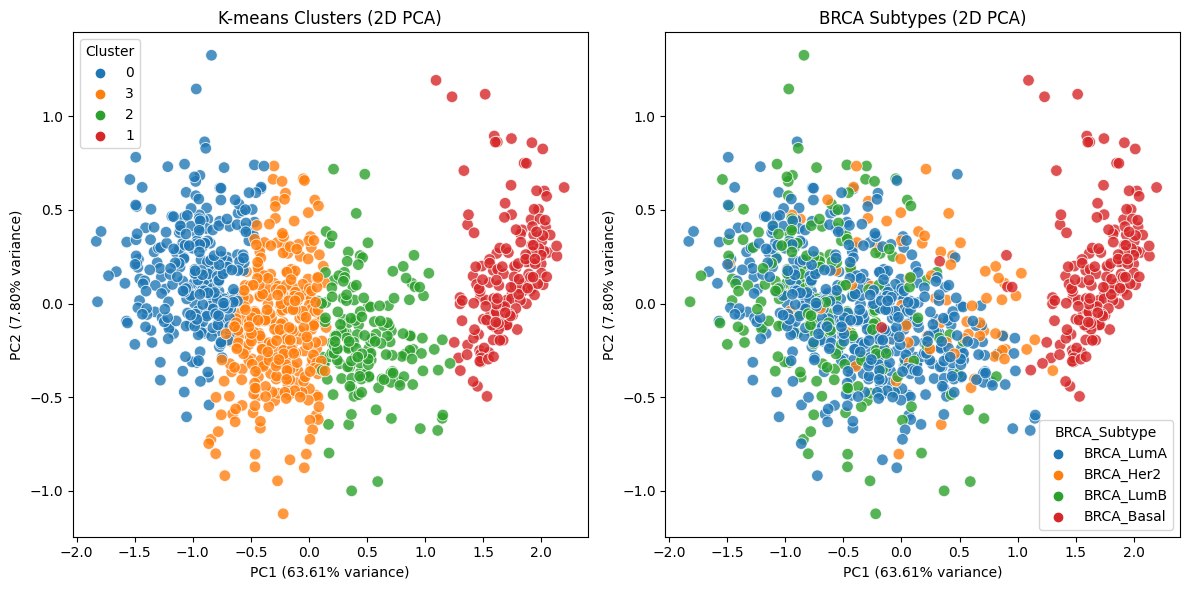

In [35]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.express as px

import plotly.io as pio
pio.renderers.default = 'iframe_connected'

# Perform PCA (3 components for 3D visualization)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(selected_features_df)
explained = pca.explained_variance_ratio_ * 100  # Explained variance

# Create DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = sample_id_store['Cluster'].astype(str).values
pca_df['BRCA_Subtype'] = merged_data['SUBTYPE'].values

# Optional: Add sample IDs if they exist in the index or in a column
if 'Sample_ID' in sample_id_store.columns:
    pca_df['Sample_ID'] = sample_id_store['Sample_ID'].values
else:
    pca_df['Sample_ID'] = sample_id_store.index  # Use index if no column

### --- 2D PCA Plots: K-means Clusters & BRCA Subtypes --- ###
plt.figure(figsize=(12, 6))

# Left: K-means clusters
plt.subplot(1, 2, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', s=70, alpha=0.8)
plt.title('K-means Clusters (2D PCA)')
plt.xlabel(f'PC1 ({explained[0]:.2f}% variance)')
plt.ylabel(f'PC2 ({explained[1]:.2f}% variance)')

# Right: True BRCA Subtypes
plt.subplot(1, 2, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='BRCA_Subtype', s=70, alpha=0.8)
plt.title('BRCA Subtypes (2D PCA)')
plt.xlabel(f'PC1 ({explained[0]:.2f}% variance)')
plt.ylabel(f'PC2 ({explained[1]:.2f}% variance)')

plt.tight_layout()
plt.show()

### --- 3D Interactive Plot with BRCA Subtypes --- ###
fig1 = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='BRCA_Subtype',
    hover_name='Sample_ID',
    title='BRCA Subtypes (3D PCA)',
    labels={
        'PC1': f'PC1 ({explained[0]:.2f}%)',
        'PC2': f'PC2 ({explained[1]:.2f}%)',
        'PC3': f'PC3 ({explained[2]:.2f}%)'
    }
)
fig1.update_traces(marker=dict(size=5, opacity=0.8))
fig1.show()

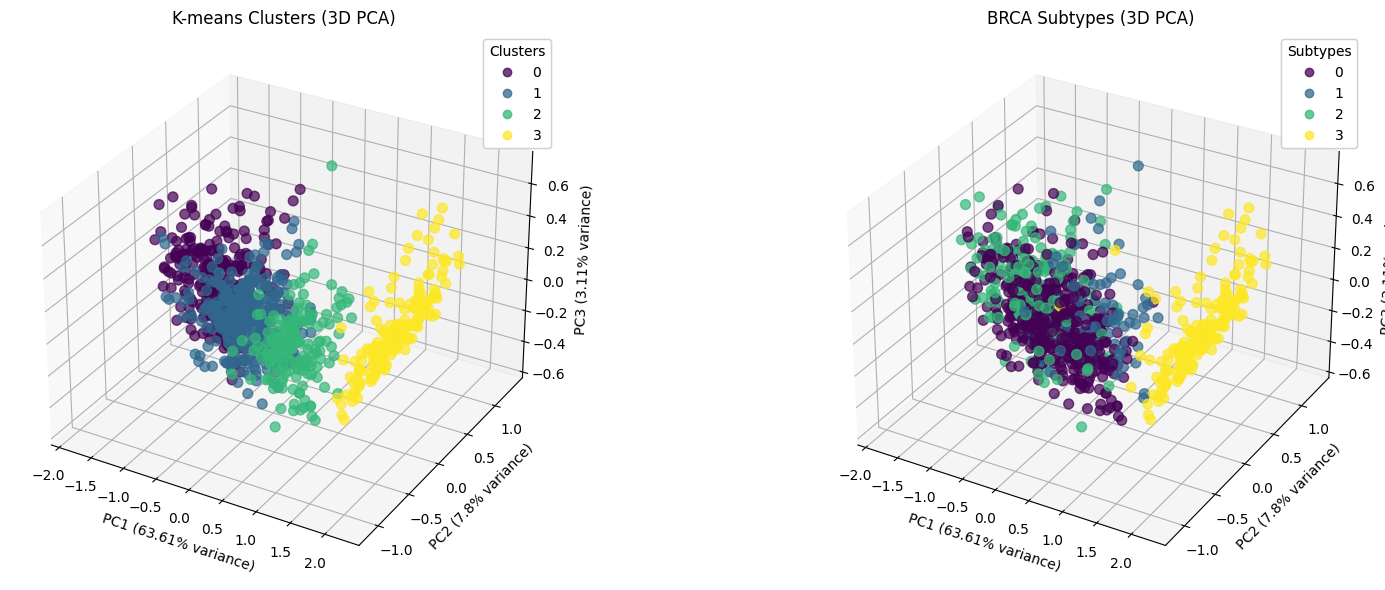

In [12]:
# Perform PCA on the transposed methylation data #Works best with 100 un-normalized features
pca = PCA(n_components=3)
pca_result = pca.fit_transform(selected_features_df)
explained = pca.explained_variance_ratio_ * 100  # Explained variance
#assert pca_result.shape[1] == 3, "PCA failed, expected 3 components"

# Plot PCA results
#plt.figure(figsize=(12, 6))

# Plot K-means clusters
#plt.subplot(1, 2, 1)
#sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=sample_id_store['Cluster'].astype(str), s=100, alpha=0.7)
#plt.title('K-means Clusters (PCA)')
#plt.xlabel(f'PC1 ({round(explained[0], 2)}% variance)')
#plt.ylabel(f'PC2 ({round(explained[1], 2)}% variance)')

# Plot actual BRCA subtypes
#plt.subplot(1, 2, 2)
#sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=merged_data['SUBTYPE'], s=100, alpha=0.7)
#plt.title('BRCA Subtypes (PCA)')
#plt.xlabel(f'PC1 ({round(explained[0], 2)}% variance)')
#plt.ylabel(f'PC2 ({round(explained[1], 2)}% variance)')

#plt.tight_layout()
#plt.show()


# Define a color map for clusters and subtypes using unique labels
unique_clusters = sample_id_store['Cluster'].unique()
cluster_cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(unique_clusters))))
cluster_colors = sample_id_store['Cluster'].map(dict(zip(unique_clusters, range(len(unique_clusters)))))
unique_subtypes = merged_data['SUBTYPE'].unique()
subtype_cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(unique_subtypes))))
subtype_colors = merged_data['SUBTYPE'].map(dict(zip(unique_subtypes, range(len(unique_subtypes)))))

# 3D Plotting
fig = plt.figure(figsize=(18, 6))

# Plot K-means clusters in 3D
ax = fig.add_subplot(121, projection='3d')
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                     c=cluster_colors, cmap=cluster_cmap, s=50, alpha=0.7)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_title('K-means Clusters (3D PCA)')
ax.set_xlabel(f'PC1 ({round(explained[0], 2)}% variance)')
ax.set_ylabel(f'PC2 ({round(explained[1], 2)}% variance)')
ax.set_zlabel(f'PC3 ({round(explained[2], 2)}% variance)')

# Plot actual BRCA subtypes in 3D
ax = fig.add_subplot(122, projection='3d')
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                     c=subtype_colors, cmap=subtype_cmap, s=50, alpha=0.7)
legend2 = ax.legend(*scatter.legend_elements(), title="Subtypes")
ax.add_artist(legend2)
ax.set_title('BRCA Subtypes (3D PCA)')
ax.set_xlabel(f'PC1 ({round(explained[0], 2)}% variance)')
ax.set_ylabel(f'PC2 ({round(explained[1], 2)}% variance)')
ax.set_zlabel(f'PC3 ({round(explained[2], 2)}% variance)')

plt.tight_layout()
plt.show()

# t-SNE AND UMAP VISUALIZATION 

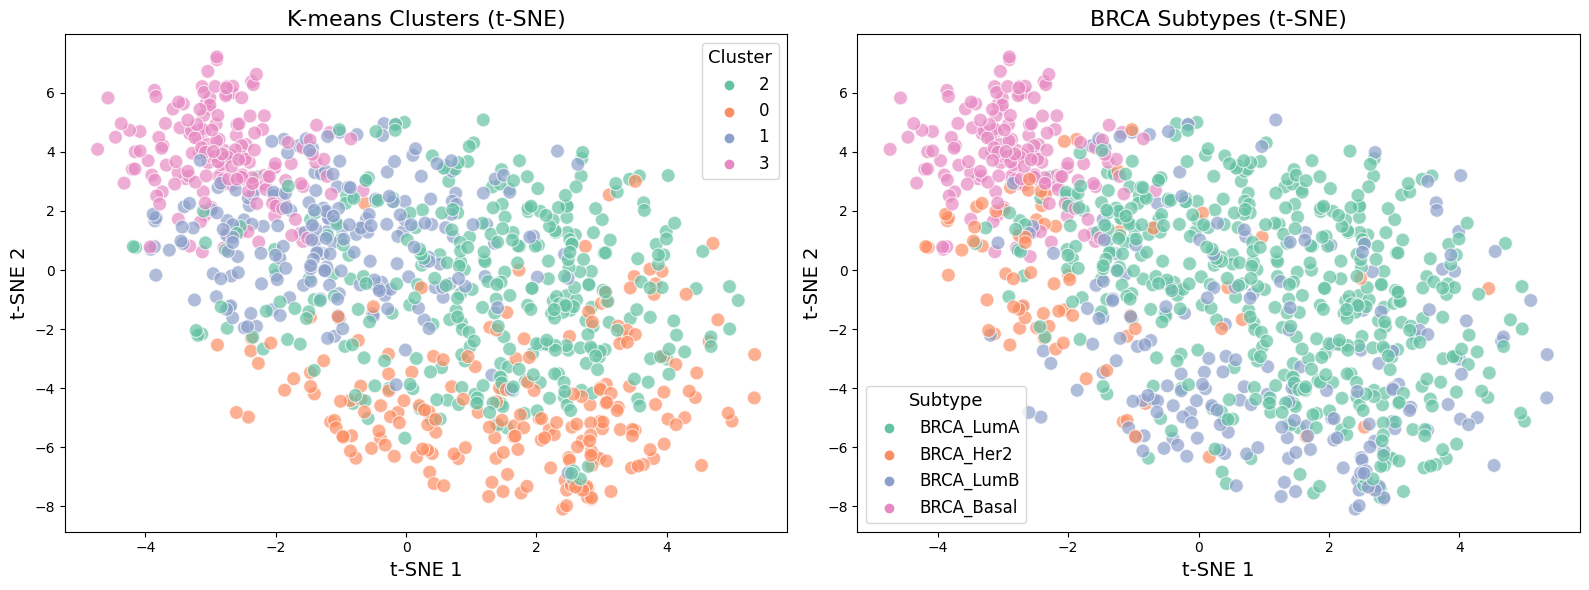

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



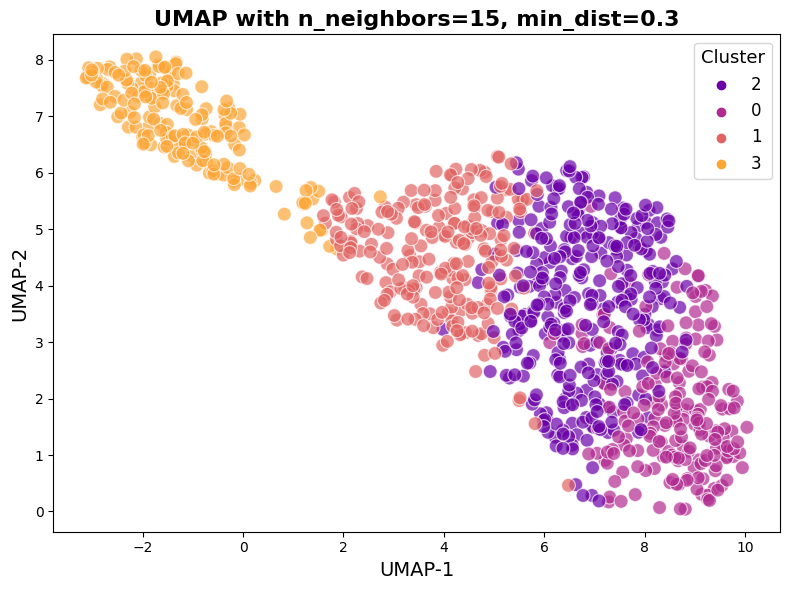

In [55]:
# Parameters for t-SNE
theAlgorithm = 'barnes_hut'
tnseDistanceMetric = 'euclidean'
exaggerationNum = 8
PCAComps = 3
PerpNum = 40

# Run t-SNE on the subset of methylation data
tsne_model = TSNE(
    n_components=3,
    random_state=1,
    perplexity=PerpNum,
    learning_rate=100,
    n_iter=2000,
    n_iter_without_progress=300,
    metric=tnseDistanceMetric,
    init='random',
    method=theAlgorithm,
    early_exaggeration=exaggerationNum
)

tsne_result = tsne_model.fit_transform(selected_features_df)

# Create a figure for t-SNE plots
plt.figure(figsize=(16, 6))

# Plot t-SNE results for clusters
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=sample_id_store['Cluster'].astype(str),
    palette='Set2',
    s=100,  # Size of points
    alpha=0.7
)
plt.title('K-means Clusters (t-SNE)', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=13)

# Plot t-SNE results for BRCA subtypes
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=merged_data['SUBTYPE'],
    palette='Set2',
    s=100,  # Size of points
    alpha=0.7
)
plt.title('BRCA Subtypes (t-SNE)', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.legend(title='Subtype', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()

# Parameters for UMAP
n_neighbors_values = 15
min_dist_values = 0.3

# Perform UMAP on the normalized methylation data with suggested parameters
umap_model = umap.UMAP(
    n_neighbors=n_neighbors_values,
    min_dist=min_dist_values,
    n_components=2,
    metric='euclidean',
    random_state=1
)
umap_result = umap_model.fit_transform(selected_features_df)

# Create a separate figure for UMAP plots
plt.figure(figsize=(8, 6))

# Plot UMAP results for clusters
sns.scatterplot(
    x=umap_result[:, 0],
    y=umap_result[:, 1],
    hue=sample_id_store['Cluster'].astype(str),
    palette='plasma',
    s=100,  # Size of points
    alpha=0.7
)
plt.title(f'UMAP with n_neighbors={n_neighbors_values}, min_dist={min_dist_values}', fontsize=16, fontweight='bold')
plt.xlabel('UMAP-1', fontsize=14)
plt.ylabel('UMAP-2', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()


# Hierarchical clustering

/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


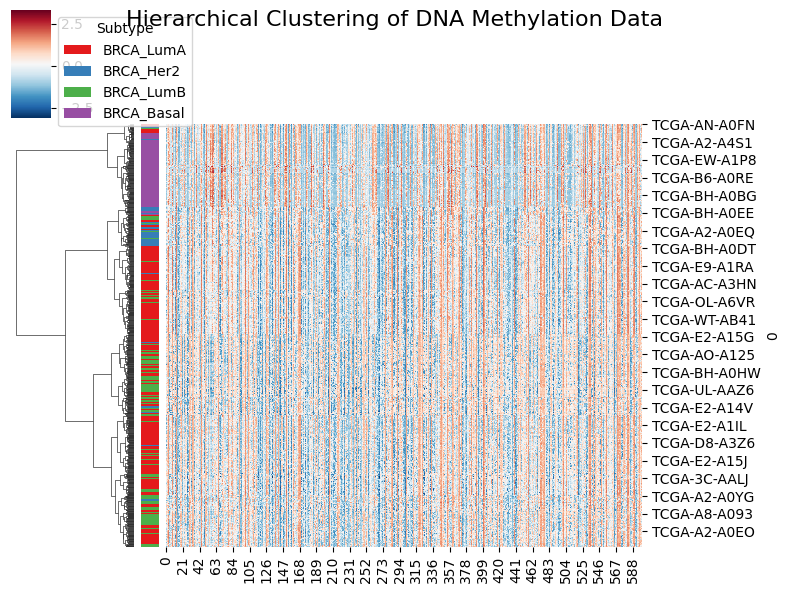

In [15]:
# Calculate the variance of each selected feature
#feature_variances = normalized_df.var(axis=0)

# Select the top 100 features with the highest variance
#top_var_features = feature_variances.nlargest(100).index
#normalized_df_filtered = normalized_df[top_var_features]

#print(f"Filtered data shape: {normalized_df_filtered.shape}")  # Should be (number of samples, 100)
# Set random seed for reproducibility
np.random.seed(1)

# Hierarchical clustering parameters
linkage_type = 'ward'  # linkage method
distance_metric = 'euclidean'  # distance metric

# Calculate pairwise distances using cosine metric
pairwise_distances = pdist(normalized_df, metric=distance_metric)

# Perform hierarchical clustering using 'complete' linkage
Z = linkage(pairwise_distances, method=linkage_type)

# Generate a color palette for the subtypes
#subtype_palette = sns.color_palette("Set1", n_colors=merged_data['SUBTYPE'].nunique())
#subtype_colors = dict(zip(merged_data['SUBTYPE'].unique(), subtype_palette))

# Create a color mapping for each sample based on the subtype
#row_colors = merged_data['SUBTYPE'].map(subtype_colors)

# Color mapping for subtypes
subtype_palette = sns.color_palette("Set1", n_colors=merged_data['SUBTYPE'].nunique())
subtype_colors = dict(zip(merged_data['SUBTYPE'].unique(), subtype_palette))
row_colors = merged_data['SUBTYPE'].map(subtype_colors).to_numpy()

# Create a clustermap using seaborn to visualize the dendrogram and heatmap
sns.clustermap(normalized_df, 
               row_cluster=True,  # Row clustering (samples)
               col_cluster=False,  # Column clustering (methylation profiles)
               method=linkage_type,
               metric=distance_metric,
               cmap='RdBu_r',  # Colormap similar to red-green
               row_colors=row_colors,  # Color bar indicating subtypes
               figsize=(8, 6),
               #vmax=2,  # Adjusting color scale for better contrast
               #vmin=-2
)

# Add a legend for the subtypes
legend_elements = [Patch(facecolor=color, label=label) for label, color in subtype_colors.items()]
plt.legend(handles=legend_elements, title='Subtype', bbox_to_anchor=(1, 1), loc='upper left')
plt.suptitle('Hierarchical Clustering of DNA Methylation Data', fontsize=16)
plt.show()


# FURTHER FEATURE SELECTION BEFORE SUPERVISED LEARNING

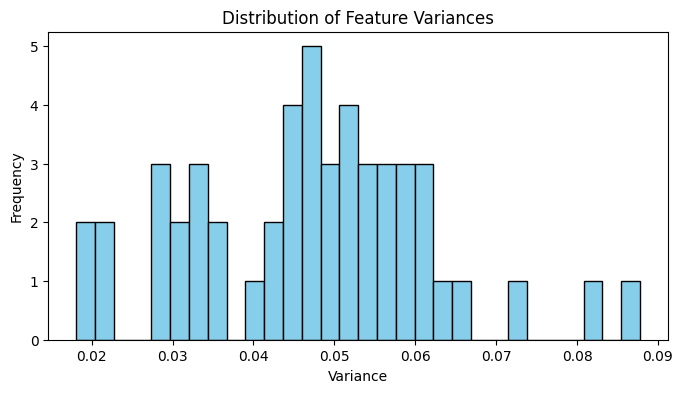

Variance statistics:
count    50.000000
mean      0.047158
std       0.014918
min       0.018106
25%       0.036200
50%       0.047740
75%       0.056991
max       0.087775
dtype: float64


In [24]:
#Trying to find the variance of my selected methylation features
variances = selected_features_df.var(axis=0)

# Plot the distribution of variances to visually inspect them
plt.figure(figsize=(8, 4))
plt.hist(variances, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Feature Variances")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.show()

# Display summary statistics of the variances to choose a threshold
print("Variance statistics:")
print(variances.describe())


# APPLYING VARIANCE THRESHOLD

In [26]:
# Set a variance threshold based on the observed distribution (e.g., 0.01)
variance_threshold = 0.04
print(f"\nApplying Variance Thresholding with threshold = {variance_threshold}")

# Initialize VarianceThreshold and fit it on the data
vt = VarianceThreshold(threshold=variance_threshold)
data_var_thresh = vt.fit_transform(selected_features_df)

# Get feature names that pass the variance threshold
features_after_variance =selected_features_df.columns[vt.get_support()]
print(f"{len(features_after_variance)} features remain after applying the variance threshold.")

# Convert the result back to a DataFrame
data_var_thresh_df = pd.DataFrame(data_var_thresh, index=selected_features_df.index, columns=features_after_variance)
display(data_var_thresh_df.head())


Applying Variance Thresholding with threshold = 0.04
36 features remain after applying the variance threshold.


GENE_POSITION  IL1A_1stExon;5'UTR  RASGRP3_TSS1500  SRI_Body  TFF1_TSS200  \
0                                                                           
TCGA-3C-AAAU             0.930852         0.348013  0.250170     0.219862   
TCGA-3C-AALI             0.805751         0.205323  0.860264     0.470822   
TCGA-3C-AALJ             0.886607         0.176521  0.470465     0.444276   
TCGA-3C-AALK             0.838020         0.542617  0.516314     0.428210   
TCGA-4H-AAAK             0.777257         0.572501  0.620854     0.448353   

GENE_POSITION  MBTD1_Body  A2ML1_1stExon;5'UTR  SCOC_1stExon;5'UTR  \
0                                                                    
TCGA-3C-AAAU     0.576730             0.914624            0.331982   
TCGA-3C-AALI     0.123832             0.934462            0.468427   
TCGA-3C-AALJ     0.768938             0.923288            0.643850   
TCGA-3C-AALK     0.382484             0.881062            0.694376   
TCGA-4H-AAAK     0.708621             0.853286            0.494313   

GENE_POSITION  PRR18_TSS1500  SOSTDC1_TSS200  SLC30A4;C15orf21_Body  ...  \
0                                                                    ...   
TCGA-3C-AAAU        0.376350        0.925070               0.277814  ...   
TCGA-3C-AALI        0.397467        0.924629               0.927749  ...   
TCGA-3C-AALJ        0.376582        0.917697               0.622532  ...   
TCGA-3C-AALK        0.391128        0.889239               0.669153  ...   
TCGA-4H-AAAK        0.407205        0.883158               0.604748  ...   

GENE_POSITION  TNFSF18_Body  SERPINA12_TSS1500  TMEM71_1stExon;5'UTR  \
0                                                                      
TCGA-3C-AAAU       0.363531           0.592041              0.762801   
TCGA-3C-AALI       0.478805           0.695912              0.164457   
TCGA-3C-AALJ       0.467883           0.685653              0.697138   
TCGA-3C-AALK       0.471241           0.460987              0.631823   
TCGA-4H-AAAK       0.570609           0.513218              0.637454   

GENE_POSITION  MEP1A_TSS200  SPP2_1stExon  PRB4_TSS1500  \
0                                                         
TCGA-3C-AAAU       0.285952      0.283399      0.286336   
TCGA-3C-AALI       0.543339      0.371037      0.537082   
TCGA-3C-AALJ       0.412489      0.588208      0.556497   
TCGA-3C-AALK       0.585859      0.652381      0.635067   
TCGA-4H-AAAK       0.563112      0.472695      0.576414   

GENE_POSITION  C3orf32_1stExon;5'UTR  DNM3_Body  EPHX1_5'UTR;TSS200  \
0                                                                     
TCGA-3C-AAAU                0.592766   0.664729            0.598874   
TCGA-3C-AALI                0.467002   0.681636            0.871363   
TCGA-3C-AALJ                0.602281   0.512090            0.563321   
TCGA-3C-AALK                0.504597   0.503012            0.454639   
TCGA-4H-AAAK                0.442277   0.606361            0.490310   

GENE_POSITION  MIA_TSS1500  
0                           
TCGA-3C-AAAU      0.873651  
TCGA-3C-AALI      0.918136  
TCGA-3C-AALJ      0.903744  
TCGA-3C-AALK      0.878785  
TCGA-4H-AAAK      0.882314  

[5 rows x 36 columns]

In [21]:
# 1. Data Preparation

## Ensure that clinical data has the same sample IDs as methylation data
print("Preparing data...")

# Ensure that the target column (subtypes) is aligned with the selected features' sample IDs
target = clinical_data_filtered.loc[selected_features_df.index, 'SUBTYPE']

# Verify that the target and features have matching indices (sample IDs)
#assert data_var_thresh_df.index.equals(target.index), "Mismatch in sample IDs between features and target data."

print("Data preparation complete. Features and target are aligned.")


Preparing data...
Data preparation complete. Features and target are aligned.


 # Random Forest Training and Evaluation

In [22]:
# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(selected_features_df , target, test_size=0.2, random_state=42, stratify=target)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 744
Test set size: 187


# XGBOOST IMPLEMANTATION

In [11]:
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from collections import Counter

#3735/30 also give good results try
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Class Mapping:")
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {idx}")

# Ensure feature names (columns) are unique
def make_column_names_unique(cols):
    counts = Counter()
    unique_cols = []
    for col in cols:
        if counts[col] == 0:
            unique_cols.append(col)
        else:
            unique_cols.append(f"{col}_{counts[col]}")
        counts[col] += 1
    return unique_cols

X_train.columns = make_column_names_unique(X_train.columns)
X_test.columns = make_column_names_unique(X_test.columns)

# Step 2: Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 5, 7],  # Removed 7
    'learning_rate': [0.2],
    'min_child_weight': [3],
    'gamma': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Initialize XGBoost
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    random_state=42
)

# Set up Stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='f1_weighted',
    cv=stratified_kfold,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit with timer
print("Starting Randomized Search for XGBoost...")
start_time = time.time()
random_search.fit(X_train, y_train_encoded)
end_time = time.time()
print(f"Time taken for tuning: {end_time - start_time:.2f} seconds")

# Evaluate best model
best_xgb = random_search.best_estimator_
print("\nBest Parameters Found:", random_search.best_params_)

y_pred_encoded = best_xgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print("\nTuned Model Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report for Tuned Model:")
print(classification_report(y_test, y_pred))

conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=label_encoder.classes_),
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)
print("\nConfusion Matrix:")
print(conf_matrix)


Class Mapping:
BRCA_Basal: 0
BRCA_Her2: 1
BRCA_LumA: 2
BRCA_LumB: 3
Starting Randomized Search for XGBoost...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Time taken for tuning: 1231.21 seconds

Best Parameters Found: {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}

Tuned Model Test Accuracy: 0.8716577540106952

Classification Report for Tuned Model:
              precision    recall  f1-score   support

  BRCA_Basal       0.97      1.00      0.99        34
   BRCA_Her2       0.86      0.75      0.80        16
   BRCA_LumA       0.86      0.95      0.90        98
   BRCA_LumB       0.80      0.62      0.70        39

    accuracy                           0.87       187
   macro avg       0.87      0.83      0.85       187
weighted avg       0.87      0.87      0.87       187


Confusion Matrix:
            BRCA_Basal  BRCA_Her2  BRCA_LumA  BRCA_LumB
BRCA_Basal          34          0          0          0
BRCA_Her2            1         12          2          1
BRCA_LumA            0          0         93          5
BRCA_LumB            0          

/tmp/ipykernel_30/2505531859.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(label_encoder.classes_))



📊 Confusion Matrix


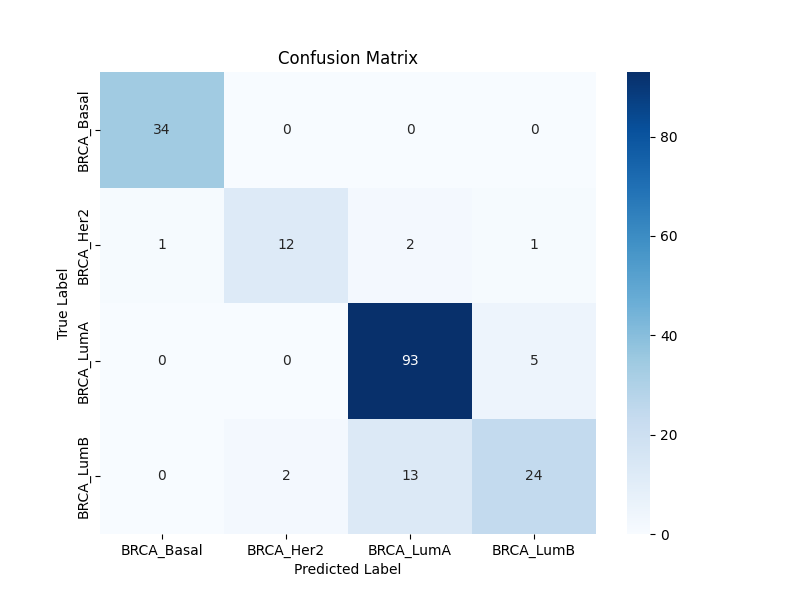


📊 Multiclass ROC Curve


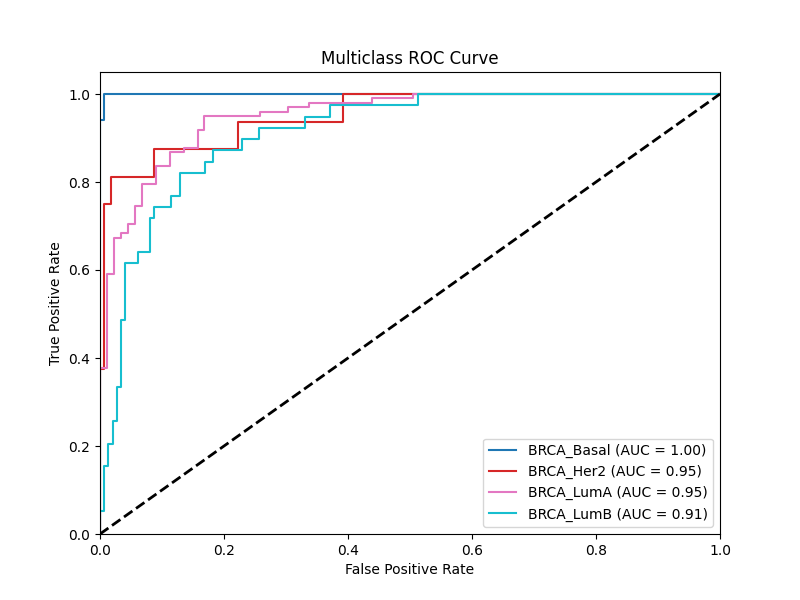


📦 Zipped all results to:


/kaggle/working/xgboost_evaluation_outputs.zip

In [15]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from IPython.display import display, FileLink, Image

# === Create output directory ===
result_dir = "xgboost_evaluation_outputs"
os.makedirs(result_dir, exist_ok=True)

# === 1. Confusion Matrix ===
conf_matrix = confusion_matrix(y_test, y_pred, labels=label_encoder.classes_)
conf_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
conf_matrix_path = os.path.join(result_dir, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.close()

# === 2. Multi-class ROC Curve ===
y_score = best_xgb.predict_proba(X_test)
y_test_bin = label_binarize(y_test_encoded, classes=range(len(label_encoder.classes_)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', len(label_encoder.classes_))
for i, class_name in enumerate(label_encoder.classes_):
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})', color=colors(i))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
roc_curve_path = os.path.join(result_dir, "roc_curve.png")
plt.savefig(roc_curve_path)
plt.close()

# === 3. Zip the results folder ===
zip_path = "xgboost_evaluation_outputs.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, _, files in os.walk(result_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, start=os.path.dirname(result_dir))
            zipf.write(file_path, arcname)

# === 4. Display plots and download links ===
print("\n Confusion Matrix")
display(Image(filename=conf_matrix_path))

print("\n Multiclass ROC Curve")
display(Image(filename=roc_curve_path))

print("\n Zipped all results to:")
display(FileLink(zip_path))


In [12]:
# Extract the selected features used in training
selected_features = X_train.columns.tolist()

# Attach the subtype labels to X_test for comparison
X_test_with_labels = X_test.copy()
X_test_with_labels['Subtype'] = y_test


In [13]:
!pip install adjustText

In [16]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

def differential_methylation_all_subtypes(X_with_labels, features, output_dir="differential_methylation_results"):
    os.makedirs(output_dir, exist_ok=True)
    subtypes = X_with_labels['Subtype'].dropna().unique()

    for target_subtype in subtypes:
        print(f"\n🔬 Analyzing subtype: {target_subtype}")

        group1 = X_with_labels[X_with_labels['Subtype'] == target_subtype]
        group2 = X_with_labels[X_with_labels['Subtype'] != target_subtype]

        p_values = []
        log2fc = []

        for feature in features:
            g1 = group1[feature].dropna()
            g2 = group2[feature].dropna()

            if len(g1) < 2 or len(g2) < 2:
                p_values.append(np.nan)
                log2fc.append(np.nan)
                continue                                                                                                              
            stat, p = ttest_ind(g1, g2, equal_var=False)
            p_values.append(p)
            mean_g1 = np.mean(g1)
            mean_g2 = np.mean(g2)
            log2fc.append(np.log2((mean_g1 + 1e-8) / (mean_g2 + 1e-8)))

        adj_p = multipletests(p_values, method='fdr_bh')[1]

        diff_df = pd.DataFrame({
            'Feature': features,
            'log2FC': log2fc,
            'p_value': p_values,
            'adj_p_value': adj_p
        }).dropna()

        def get_category(row):
            if row['adj_p_value'] < 0.05 and row['log2FC'] >= 1:
                return 'Hypermethylated'
            elif row['adj_p_value'] < 0.05 and row['log2FC'] <= -1:
                return 'Hypomethylated'
            else:
                return 'Not Significant'

        diff_df['Category'] = diff_df.apply(get_category, axis=1)

        # Count stats
        total_sig = (diff_df['Category'] != 'Not Significant').sum()
        num_hyper = (diff_df['Category'] == 'Hypermethylated').sum()
        num_hypo = (diff_df['Category'] == 'Hypomethylated').sum()

        print(f"📌 Stats for {target_subtype}:")
        print(f"   Total significant methylated genes: {total_sig}")
        print(f"   Hypermethylated genes: {num_hyper}")
        print(f"   Hypomethylated genes: {num_hypo}")


        # Save all results
        diff_df.to_csv(os.path.join(output_dir, f"diff_methylation_{target_subtype}.csv"), index=False)

        # Save top 15 significant markers
        top_df = diff_df[(diff_df['adj_p_value'] < 0.05)].copy()
        top_df['abs_log2FC'] = np.abs(top_df['log2FC'])
        top15 = top_df.sort_values('abs_log2FC', ascending=False).head(15)
        top15.drop(columns='abs_log2FC', inplace=True)
        top15.to_csv(os.path.join(output_dir, f"top15_diff_methylation_{target_subtype}.csv"), index=False)

        print(f"✅ Saved full + top 15 results for {target_subtype}")

        # Volcano plot (no labels)
        plt.figure(figsize=(6, 4))
        sns.scatterplot(
            data=diff_df,
            x='log2FC',
            y=-np.log10(diff_df['adj_p_value']),
            hue='Category',
            palette={
                'Hypermethylated': 'red',
                'Hypomethylated': 'blue',
                'Not Significant': 'gray'
            },
            alpha=0.7,
            edgecolor=None,
            linewidth=0,
            s=15
        )
        plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=0.8)
        plt.axvline(1, color='black', linestyle='--', linewidth=0.8)
        plt.axvline(-1, color='black', linestyle='--', linewidth=0.8)

        plt.title(f"Volcano Plot: {target_subtype}", fontsize=10)
        plt.xlabel("log2 Fold Change", fontsize=8)
        plt.ylabel("-log10 Adjusted p-value", fontsize=8)
        plt.legend(title='Category', title_fontsize=7, fontsize=6, loc='upper left', bbox_to_anchor=(1, 1))
        plt.tight_layout(pad=0.5, rect=[0, 0, 0.85, 1])

        plot_path = os.path.join(output_dir, f"volcano_{target_subtype}.png")
        plt.savefig(plot_path, dpi=300)
        plt.close()
        print(f"📊 Volcano plot saved to {plot_path}")

# Example usage (replace with your actual data)
differential_methylation_all_subtypes(X_with_labels=X_test_with_labels, features=X_test.columns)



🔬 Analyzing subtype: BRCA_LumA
📌 Stats for BRCA_LumA:
   Total significant methylated genes: 26
   Hypermethylated genes: 9
   Hypomethylated genes: 17
✅ Saved full + top 15 results for BRCA_LumA
📊 Volcano plot saved to differential_methylation_results/volcano_BRCA_LumA.png

🔬 Analyzing subtype: BRCA_LumB
📌 Stats for BRCA_LumB:
   Total significant methylated genes: 102
   Hypermethylated genes: 101
   Hypomethylated genes: 1
✅ Saved full + top 15 results for BRCA_LumB
📊 Volcano plot saved to differential_methylation_results/volcano_BRCA_LumB.png

🔬 Analyzing subtype: BRCA_Her2
📌 Stats for BRCA_Her2:
   Total significant methylated genes: 55
   Hypermethylated genes: 1
   Hypomethylated genes: 54
✅ Saved full + top 15 results for BRCA_Her2
📊 Volcano plot saved to differential_methylation_results/volcano_BRCA_Her2.png

🔬 Analyzing subtype: BRCA_Basal
📌 Stats for BRCA_Basal:
   Total significant methylated genes: 974
   Hypermethylated genes: 54
   Hypomethylated genes: 920
✅ Saved full


📊 Volcano plot for BRCA_Basal


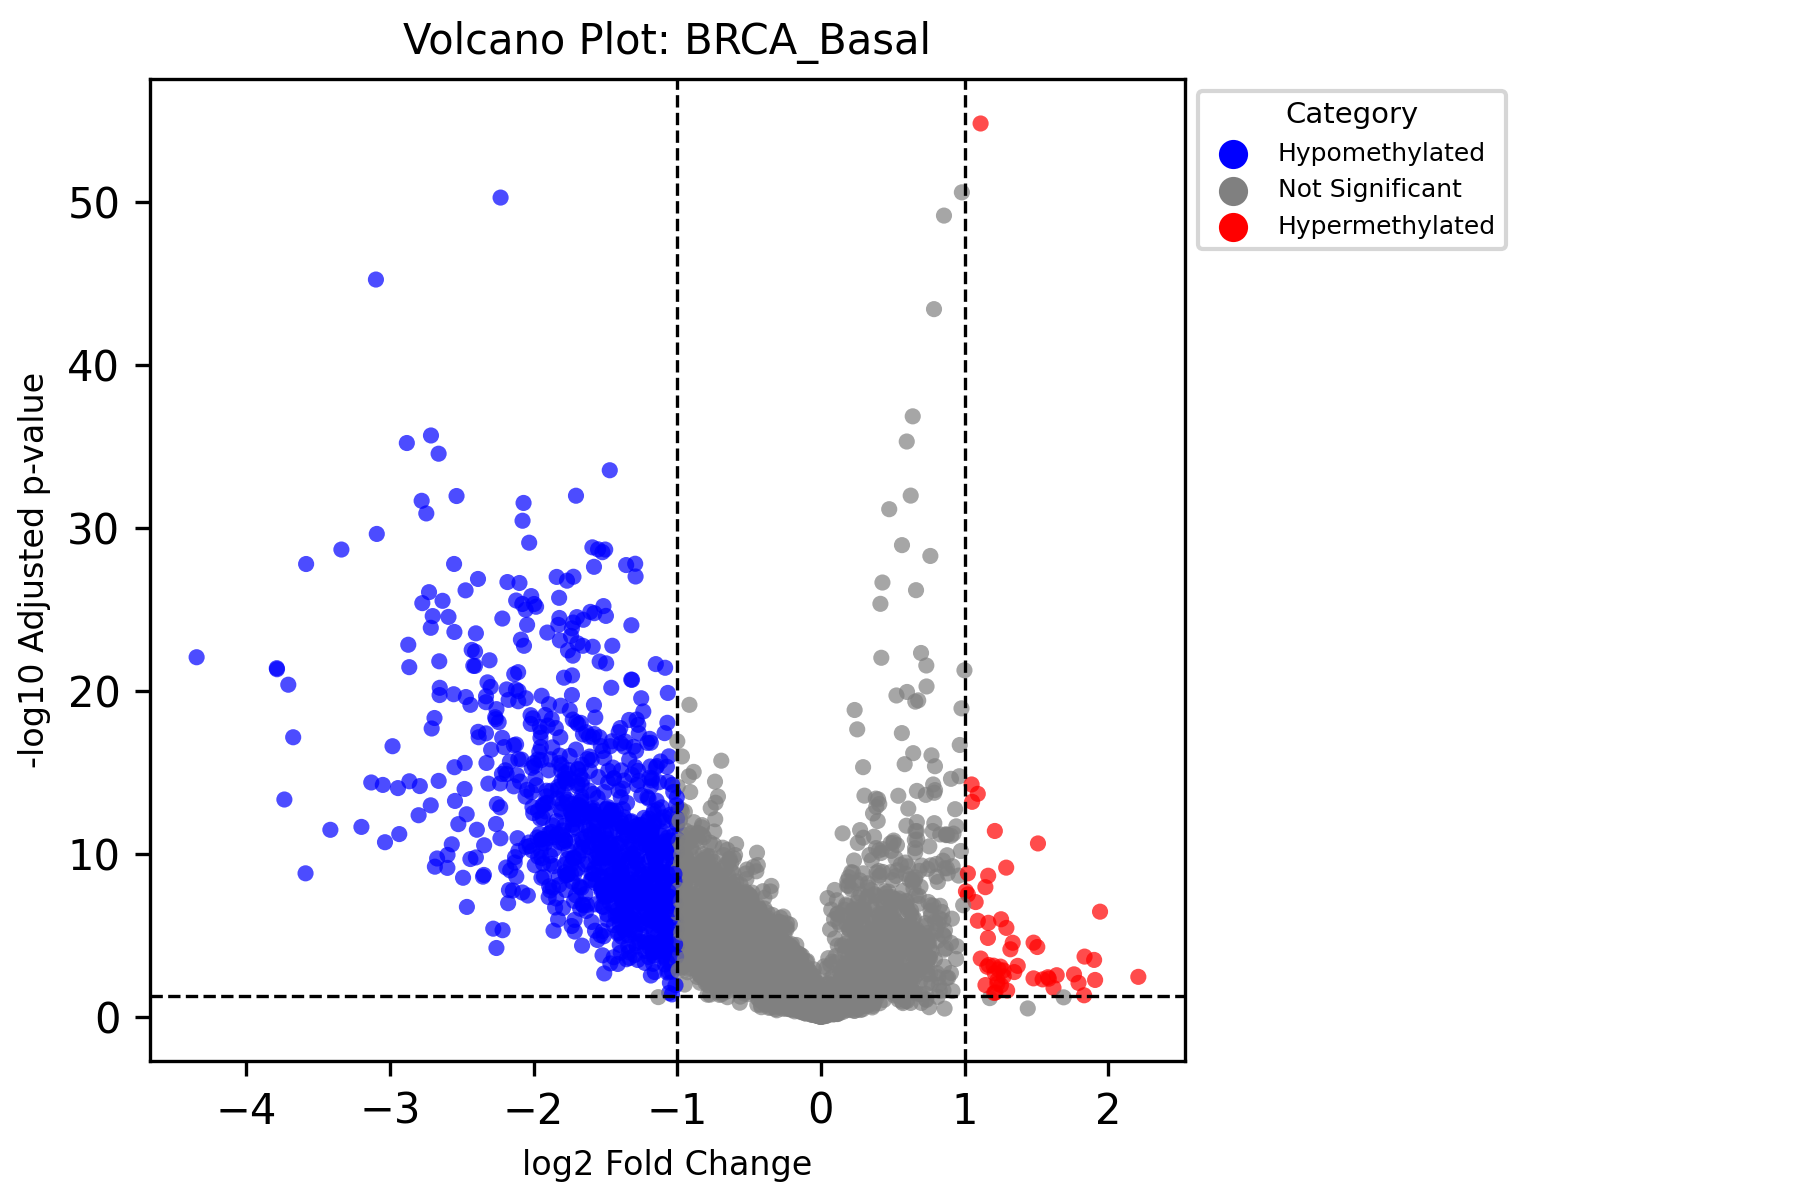

⬇️ Download CSV for BRCA_Basal:


/kaggle/working/differential_methylation_results/diff_methylation_BRCA_Basal.csv


📊 Volcano plot for BRCA_Her2


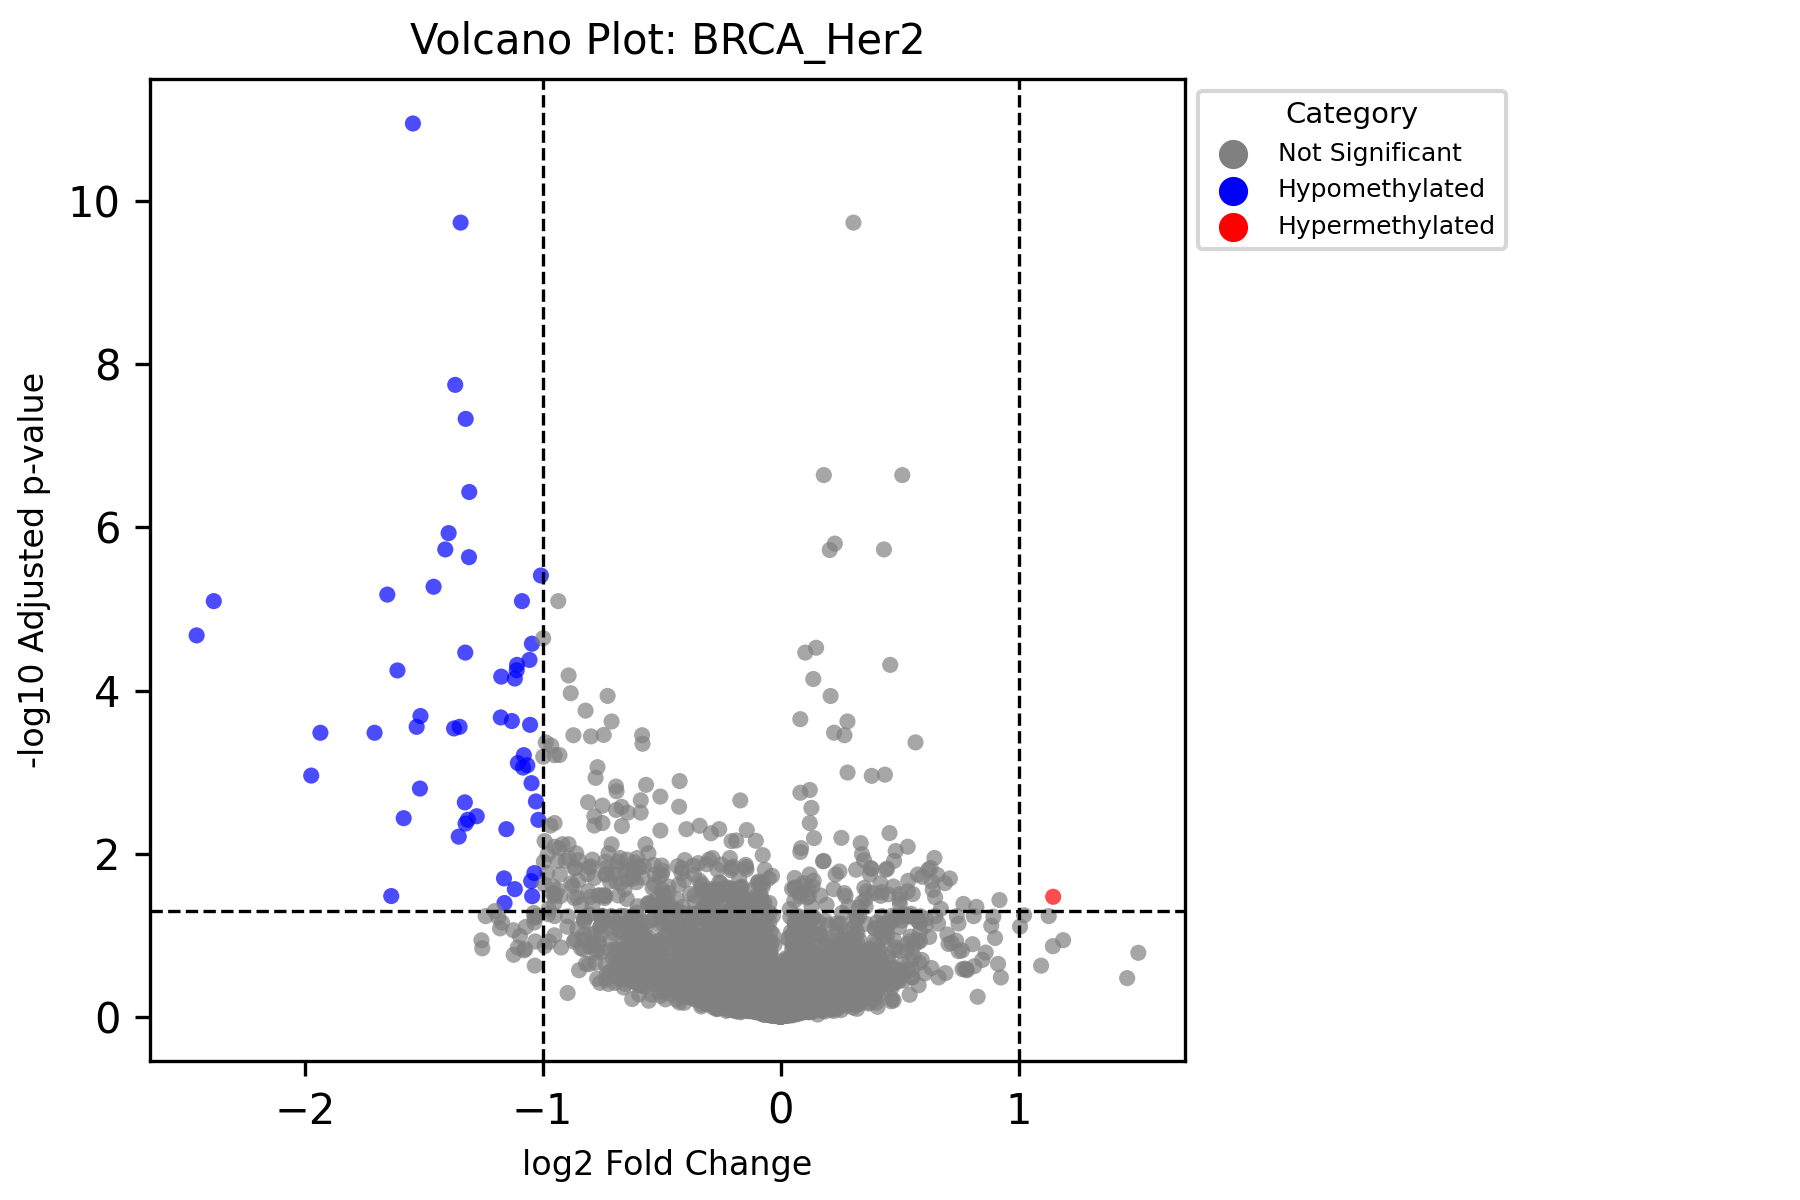

⬇️ Download CSV for BRCA_Her2:


/kaggle/working/differential_methylation_results/diff_methylation_BRCA_Her2.csv


📊 Volcano plot for BRCA_LumA


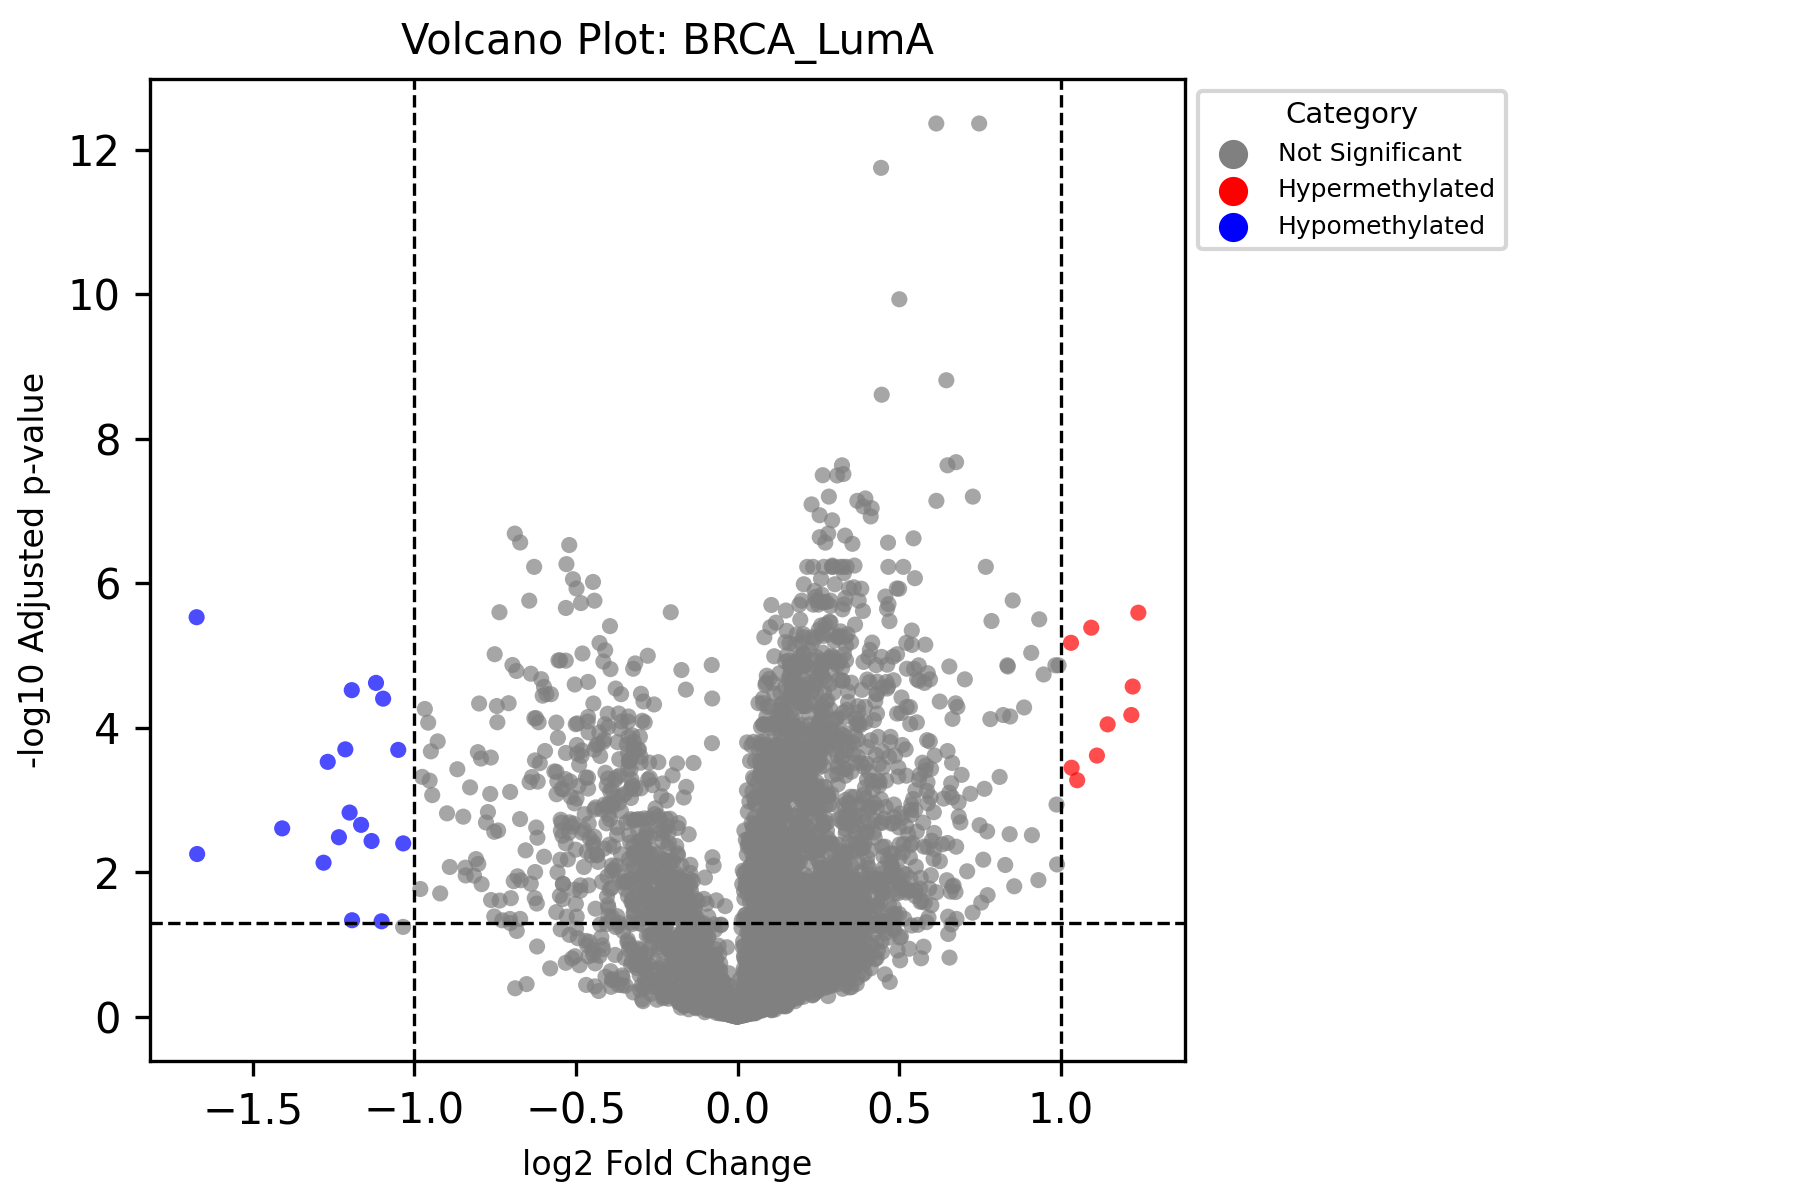

⬇️ Download CSV for BRCA_LumA:


/kaggle/working/differential_methylation_results/diff_methylation_BRCA_LumA.csv


📊 Volcano plot for BRCA_LumB


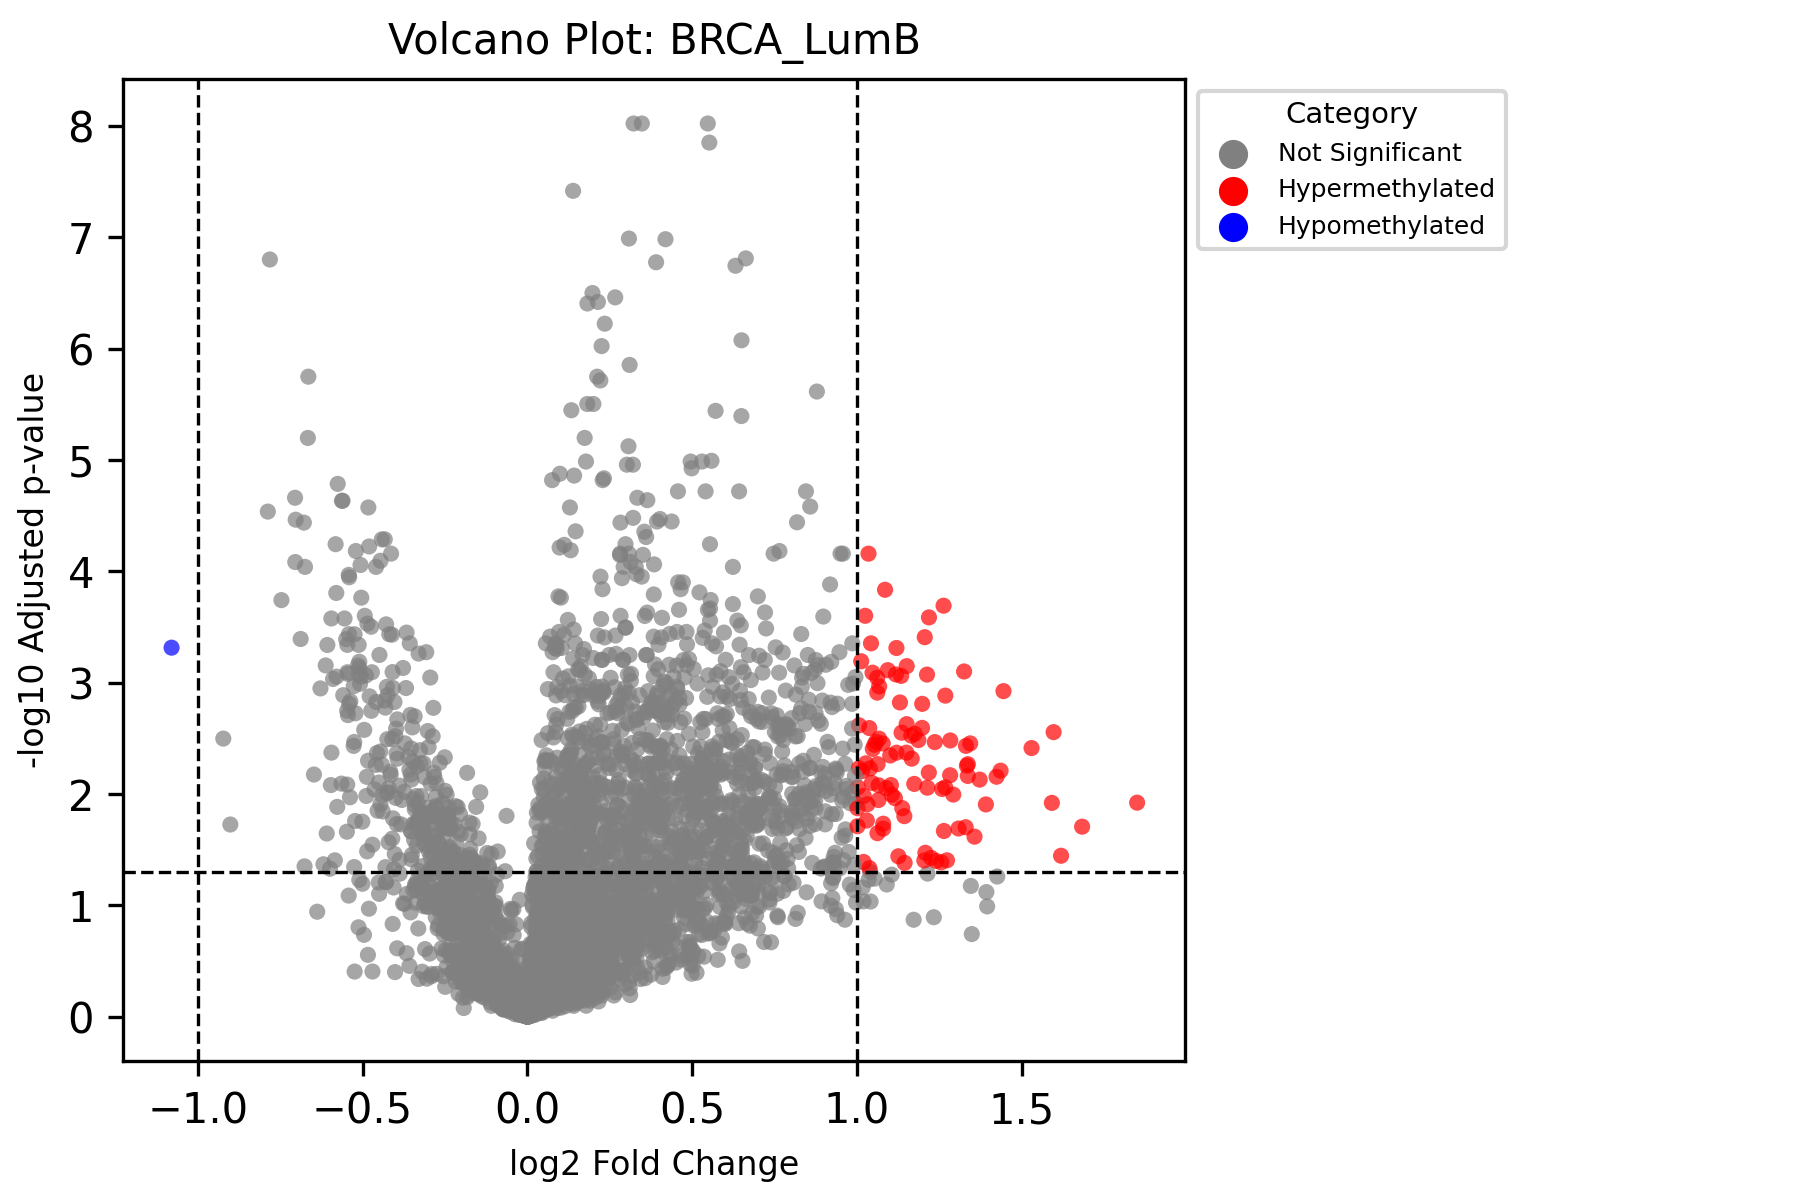

⬇️ Download CSV for BRCA_LumB:


/kaggle/working/differential_methylation_results/diff_methylation_BRCA_LumB.csv


📦 Zipped all results to: differential_methylation_results.zip


/kaggle/working/differential_methylation_results.zip

In [15]:
import os
import zipfile
from IPython.display import display, FileLink, Image

# Path to the output directory
result_dir = "differential_methylation_results"
zip_path = "differential_methylation_results.zip"

# Get subtypes from saved volcano plots
subtypes = sorted(set(
    f.replace("volcano_", "").replace(".png", "") 
    for f in os.listdir(result_dir) 
    if f.startswith("volcano_")
))

# Display plots and download links
for subtype in subtypes:
    print(f"\n Volcano plot for {subtype}")
    display(Image(filename=f"{result_dir}/volcano_{subtype}.png"))

    csv_path = f"{result_dir}/diff_methylation_{subtype}.csv"
    if os.path.exists(csv_path):
        print(f" Download CSV for {subtype}:")
        display(FileLink(csv_path))
    else:
        print(" CSV not found.")

# Zip the full result folder for easy download
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, _, files in os.walk(result_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, start=os.path.dirname(result_dir))
            zipf.write(file_path, arcname)

print(f"\n Zipped all results to: {zip_path}")
display(FileLink(zip_path))


In [ ]:
import time
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter

# --- Data Prep (unchanged) ---
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Class Mapping:")
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {idx}")

# Ensure unique column names
def make_column_names_unique(cols):
    counts = Counter()
    unique_cols = []
    for col in cols:
        if counts[col] == 0:
            unique_cols.append(col)
        else:
            unique_cols.append(f"{col}_{counts[col]}")
        counts[col] += 1
    return unique_cols

X_train.columns = make_column_names_unique(X_train.columns)
X_test.columns = make_column_names_unique(X_test.columns)

# --- LightGBM Parameter Grid ---
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 5, 7],          # LightGBM can handle deeper trees efficiently
    'learning_rate': [0.1, 0.2],      # Test lower rates (LightGBM is sensitive to this)
    'num_leaves': [15, 31, 63],       # Key parameter! Should be <= 2^max_depth
    'min_child_samples': [5, 10, 20], # Similar to min_child_weight in XGBoost
    'subsample': [0.8, 0.9],          # Stochastic sampling
    'colsample_bytree': [0.8, 0.9],   # Feature subsampling
    'reg_alpha': [0, 0.1],            # L1 regularization
    'reg_lambda': [0, 0.1],           # L2 regularization
}

# Initialize LightGBM
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    random_state=42,
    n_jobs=-1,                        # Use all cores
    verbose=-1                        # Silence LightGBM output
)

# --- RandomizedSearchCV (unchanged structure) ---
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=20,                        # Increase iterations for broader search
    scoring='f1_weighted',
    cv=stratified_kfold,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# --- Train with Timer ---
print("Starting Randomized Search for LightGBM...")
start_time = time.time()
random_search.fit(X_train, y_train_encoded)
end_time = time.time()
print(f"Time taken for tuning: {end_time - start_time:.2f} seconds")

# --- Evaluate Best Model ---
best_lgb = random_search.best_estimator_
print("\nBest Parameters Found:", random_search.best_params_)

y_pred_encoded = best_lgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print("\nTuned LightGBM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report for Tuned LightGBM:")
print(classification_report(y_test, y_pred))

conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=label_encoder.classes_),
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)
print("\nConfusion Matrix:")
print(conf_matrix)

Class Mapping:
BRCA_Basal: 0
BRCA_Her2: 1
BRCA_LumA: 2
BRCA_LumB: 3
Starting Randomized Search for LightGBM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, min_child_samples=20, n_estimators=500, num_leaves=63, reg_alpha=0.1, reg_lambda=0, subsample=0.8; total time=  36.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=63, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8; total time= 1.5min


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Class Mapping:")
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {idx}")

# Define the parameter space
param_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0.0, 0.5),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 1.0)
}

# Initialize Bayesian optimization
bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    n_iter=50,
    scoring='accuracy'
    #scoring='f1_weighted',
    cv=stratified_kfold,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit with timer
print("Starting Bayesian Optimization for XGBoost...")
start_time = time.time()
bayes_search.fit(X_train, y_train_encoded)
end_time = time.time()
print(f"Time taken for tuning: {end_time - start_time:.2f} seconds")

# Evaluate best model
best_xgb = bayes_search.best_estimator_
print("\nBest Parameters Found:", bayes_search.best_params_)

y_pred_encoded = best_xgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
print("\nTuned Model Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report for Tuned Model:")
print(classification_report(y_test, y_pred))

conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=label_encoder.classes_),
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)
print("\nConfusion Matrix:")
print(conf_matrix)

In [ ]:
# 3. Model Training
print("\nTraining Random Forest model...")

# Define the parameter grid for Randomized Search
param_grid = {
    'n_estimators': [300],
    'max_depth': [10, 15, 20], #removed none and 25
    'min_samples_split': [5, 10, 12],# For now I will remove 1,2,4, 12
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.1, 0.3, 0.5],

    
}

param_grid_gb = {
    'n_estimators': [100, 200],  # Number of boosting stages
    'learning_rate': [0.1],  # Smaller learning rates can improve performance
    'max_depth': [3],  # Control the depth of the trees
    'min_samples_split': [10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [2],  # Min vfimum samples required to be at a leaf node
    'subsample': [0.8],  # Fraction of samples to be used for fitting the individual base learners
    'max_features': ['log2']  # Number of features to consider at each split
}

# Initialize Random Forest classifier with default parameters (you can tune these later)
rf = RandomForestClassifier(random_state=42)

# Use StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use RandomizedSearchCV to search for the best parameters
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings sampled
    scoring= 'f1_macro',  # Track multiple metrics next we try 
    #refit='f1_macro',  # Choose which metric to prioritize
    cv=stratified_kfold,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
   
)

# For Gradient Boosting
random_search_gb = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_grid_gb,
    n_iter=20,
    scoring='f1_macro',
    cv=stratified_kfold,
    verbose=2,
    random_state=42,
    
)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Display the best parameters and best score
print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score (weighted F1):", random_search.best_score_)


# Train the Random Forest with the best parameters found
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)


print("Random Forest model training complete.")

# 4. Model Evaluation
print("\nEvaluating model performance...")

# Evaluate the tuned model
y_pred_tuned = best_rf.predict(X_test)
print("\nTuned Model Test Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report for Tuned Model:")
print(classification_report(y_test, y_pred_tuned))


# Display confusion matrix
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_tuned), index=best_rf.classes_, columns=best_rf.classes_))

# Get feature importances from the previous best model
feature_importances = best_rf.feature_importances_

# Set a threshold for feature importance (you might start with 0.01 and adjust)
importance_threshold = 0.01
important_features = [f for f, importance in zip(X_train.columns, feature_importances) if importance > importance_threshold]

# Filter to keep only important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

# 14. Fit the randomized search to the resampled data
random_search_gb.fit(X_train, y_train)

# 15. Display the best parameters and best score for Gradient Boosting
print("Best parameters found for Gradient Boosting:", random_search_gb.best_params_)
print("Best cross-validation score (weighted F1) for Gradient Boosting:", random_search_gb.best_score_)

# 16. Train the Gradient Boosting model with the best parameters found
best_gb = random_search_gb.best_estimator_
best_gb.fit(X_train, y_train)

# 17. Evaluate the Gradient Boosting model
print("\nEvaluating Gradient Boosting model performance...")
y_pred_gb = best_gb.predict(X_test)
print("\nGradient Boosting Test Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report for Gradient Boosting Model:")
print(classification_report(y_test, y_pred_gb))
print("\nConfusion Matrix for Gradient Boosting:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_gb), index=best_gb.classes_, columns=best_gb.classes_))


In [ ]:
# 3. Model Training
print("\nTraining Random Forest model...")

# Define the parameter grid for Randomized Search
param_grid = {
    'n_estimators': [300],
    'max_depth': [10, 15, 20], #removed none and 25
    'min_samples_split': [5, 10, 12],# For now I will remove 1,2,4, 12
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.1, 0.3, 0.5],
}

# Initialize Random Forest classifier with default parameters (you can tune these later)
rf = RandomForestClassifier(random_state=42)

# Use StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use RandomizedSearchCV to search for the best parameters
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings sampled
    scoring= 'f1_macro',  # Track multiple metrics next we try 
    #refit='f1_macro',  # Choose which metric to prioritize
    cv=stratified_kfold,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Display the best parameters and best score
print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score (weighted F1):", random_search.best_score_)

# Train the Random Forest with the best parameters found
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

print("Random Forest model training complete.")

# 4. Model Evaluation
print("\nEvaluating model performance...")

# Evaluate the tuned model
y_pred_tuned = best_rf.predict(X_test)
print("\nTuned Model Test Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report for Tuned Model:")
print(classification_report(y_test, y_pred_tuned))

# Display confusion matrix
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_tuned), index=best_rf.classes_, columns=best_rf.classes_))

